# 02 Synology C2 Exploratory Analysis

Objective 2 focuses on profiling C2 adoption by region, customer tier, and SKU while preparing the dataset that will underpin the `analytics.c2_adoption_scorecard` table.


## Analysis Checklist

- Verify C2 records in the cleaned sales snapshot.
- Segment results by service family, plan variant, region, and derived customer tiers.
- Produce a monthly scorecard aligned with the warehouse schema and save it for review.


In [17]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 180)


In [18]:
def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data" / "processed").exists() and (candidate / "src").exists():
            return candidate
    return start

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = Path(os.environ.get("SYNOBI_REPO_ROOT", find_project_root(NOTEBOOK_ROOT)))
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "synosales_cleaned.parquet"
OUTPUT_DIR = PROJECT_ROOT / "notebook_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH


PosixPath('/Users/tonychu/Git Repository/syno_prediction/data/processed/synosales_cleaned.parquet')

In [19]:
raw_sales = pd.read_parquet(DATA_PATH)
raw_sales.columns = raw_sales.columns.str.strip()

print(f"Loaded {len(raw_sales):,} rows from {DATA_PATH}")
raw_sales.head()


Loaded 205,708 rows from /Users/tonychu/Git Repository/syno_prediction/data/processed/synosales_cleaned.parquet


,PI,Customer,ItemCode,Product,Currency,Price,Quantity,Discount,T/T Discount,Total,ShipDate,InvDate,DeliveryFrom,Destination,Comments,Country,ShipTo,source_sheet,Type,sub_cat,exchange_rate_to_usd,usd_adjusted_price,usd_adjusted_total,Year,Region,Capacity,Unit,total_cap,Bays,total_bays
0,2364503.0,C2,None,C2 Storage Advanced,EUR,104.69,1,0.0,0.0,104.69,2023-01-01,2023-01-01,EU,Andorra,None,Andorra,None,2023-C2,C2-HYBRID,C2-STORAGE-UNKNOWN-ADVANCED,1.05,109.9245,109.9245,2023,FR,NaN,None,0,NaN,NaN
1,2364504.0,C2,None,C2 Storage Basic,EUR,35.33,1,0.0,0.0,35.33,2023-01-01,2023-01-01,EU,Andorra,None,Andorra,None,2023-C2,C2-HYBRID,C2-STORAGE-UNKNOWN-BASIC,1.05,37.0965,37.0965,2023,FR,NaN,None,0,NaN,NaN
2,2364505.0,C2,None,C2 Storage Basic,USD,1.96,1,0.0,0.0,1.96,2023-01-01,2023-01-01,US,Andorra,None,Andorra,None,2023-C2,C2-HYBRID,C2-STORAGE-UNKNOWN-BASIC,1.00,1.9600,1.9600,2023,FR,NaN,None,0,NaN,NaN
3,2364506.0,C2,None,Active Insight Premium Early Bird,EUR,12.53,1,0.0,0.0,12.53,2023-01-01,2023-01-01,EU,United Arab Emirates,None,United Arab Emirates,None,2023-C2,C2-HYBRID,Other,1.05,13.1565,13.1565,2023,HQ,NaN,None,0,NaN,NaN
4,2364507.0,C2,None,C2 Storage Advanced,EUR,1246.98,1,0.0,0.0,1246.98,2023-01-01,2023-01-01,EU,United Arab Emirates,None,United Arab Emirates,None,2023-C2,C2-HYBRID,C2-STORAGE-UNKNOWN-ADVANCED,1.05,1309.3290,1309.3290,2023,HQ,NaN,None,0,NaN,NaN


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Reuse the cleaned parquet already loaded as raw_sales to stay within repo inputs.
df = raw_sales.copy()

# Normalize timestamps and derive a Year/Month snapshot for subscription cohorting.
df['InvDate'] = pd.to_datetime(df['InvDate'], errors='coerce')
df = df.dropna(subset=['InvDate']).copy()
df['YearMonth'] = df['InvDate'].dt.to_period('M').dt.to_timestamp()

# Basic coercions to keep numeric metrics usable downstream.
df['usd_adjusted_total'] = pd.to_numeric(df.get('usd_adjusted_total'), errors='coerce').fillna(0.0)
df['usd_adjusted_price'] = pd.to_numeric(df.get('usd_adjusted_price'), errors='coerce')
df['Quantity'] = (
    pd.to_numeric(df.get('Quantity'), errors='coerce')
    .fillna(0)
    .astype(int)
)
for col in ['Product', 'Customer', 'Region', 'Country', 'Type']:
    if col in df.columns:
        df[col] = df[col].astype(str)
    else:
        df[col] = ''

# ---- 1) Identify Subscription SKUs (heuristic) ----
subscription_keywords = [
    r"\bC2\b", r"\bC2 ", r"C2-", r"C2_", r"Active Insight", r"ActiveProtect", r"\bC2 Storage\b",
    r"\bC2 Backup\b", r"\bC2 Password\b", r"\bC2 Transfer\b", r"\bC2 Object\b"
]
pattern = re.compile("|".join(subscription_keywords), flags=re.IGNORECASE)
df['is_subscription'] = df['Product'].apply(lambda name: bool(pattern.search(name)))
subs = df[df['is_subscription']].copy()

# Normalize into product families for consistent aggregation.
def family_from_product(product_name: str) -> str:
    name = (product_name or '').lower()
    if 'active insight' in name:
        return 'Active Insight'
    if 'activeprotect' in name or 'active protect' in name:
        return 'ActiveProtect'
    if 'c2 password' in name:
        return 'C2 Password'
    if 'c2 backup' in name:
        return 'C2 Backup'
    if 'c2 storage' in name or ('object' in name and 'c2' in name):
        return 'C2 Storage/Object'
    if 'c2 transfer' in name:
        return 'C2 Transfer'
    if 'c2' in name:
        return 'C2 (Other)'
    return 'Other'

subs['Family'] = subs['Product'].apply(family_from_product)

# ---- 2) Monthly MRR proxy & active subs ----
mrr = (
    subs.groupby(['YearMonth', 'Family'])['usd_adjusted_total']
    .sum()
    .rename('MRR')
    .reset_index()
)
active_subs = (
    subs.groupby(['YearMonth', 'Family'])['Customer']
    .nunique()
    .rename('ActiveSubs')
    .reset_index()
)
monthly = pd.merge(mrr, active_subs, on=['YearMonth', 'Family'], how='outer').fillna(0)
monthly['ARR'] = monthly['MRR'] * 12

# ---- 3) Global totals per month (all families) ----
mrr_total = monthly.groupby('YearMonth')['MRR'].sum().rename('MRR_Total')
actives_total = monthly.groupby('YearMonth')['ActiveSubs'].sum().rename('ActiveSubs_Total')
arr_total = (mrr_total * 12).rename('ARR_Total')
total_monthly = pd.concat([mrr_total, arr_total, actives_total], axis=1).reset_index()

# ---- 4) MoM Growth, Churn (logo & revenue) ----
paid = subs.groupby(['YearMonth', 'Customer', 'Family'])['usd_adjusted_total'].sum().reset_index()

def logo_mom_stats(df_paid: pd.DataFrame) -> pd.DataFrame:
    pivot = (
        df_paid.assign(Active=lambda d: d['usd_adjusted_total'] > 0)
        .pivot_table(index=['Customer', 'Family'], columns='YearMonth', values='Active', aggfunc='max')
        .fillna(False)
    ).astype(bool)
    months = pivot.columns
    results = []
    for i in range(1, len(months)):
        prev_col, cur_col = months[i - 1], months[i]
        prev_active = pivot[prev_col]
        cur_active = pivot[cur_col]
        results.append({
            'Month': cur_col,
            'NewLogos': int((~prev_active & cur_active).sum()),
            'ChurnedLogos': int((prev_active & ~cur_active).sum()),
            'NetLogos': int((cur_active.astype(int) - prev_active.astype(int)).sum()),
        })
    return pd.DataFrame(results)

logo_stats = logo_mom_stats(paid)

rev = paid.pivot_table(
    index=['Customer', 'Family'], columns='YearMonth', values='usd_adjusted_total', aggfunc='sum'
).fillna(0.0)

rev_components = []
months = list(rev.columns)
for i in range(1, len(months)):
    prev_month = months[i - 1]
    cur_month = months[i]
    prev_rev = rev[prev_month]
    cur_rev = rev[cur_month]
    kept = np.minimum(prev_rev, cur_rev).sum()
    expansion = (cur_rev - prev_rev.clip(upper=cur_rev)).clip(lower=0).sum()
    contraction = (prev_rev - cur_rev.clip(upper=prev_rev)).clip(lower=0).sum()
    churn = (prev_rev - cur_rev).clip(lower=0).sum()
    rev_components.append({
        'Month': cur_month,
        'KeptRevenue': kept,
        'ExpansionRevenue': expansion,
        'ContractionRevenue': contraction,
        'ChurnedRevenue': churn,
        'NetChange': cur_rev.sum() - prev_rev.sum(),
    })

revenue_churn = pd.DataFrame(rev_components)

# ---- 5) Cohort/Retention ----
paid['YearMonth'] = paid['YearMonth'].dt.to_period('M').dt.to_timestamp()
first_month = (
    paid[paid['usd_adjusted_total'] > 0]
    .groupby(['Customer', 'Family'])['YearMonth']
    .min()
    .rename('Cohort')
)
cohort_df = paid.merge(first_month, on=['Customer', 'Family'])
cohort_period = cohort_df['Cohort'].dt.to_period('M')
year_month_period = cohort_df['YearMonth'].dt.to_period('M')
cohort_df['MonthsSinceStart'] = (year_month_period.astype('int64') - cohort_period.astype('int64')).astype(int)
retention = (
    cohort_df[cohort_df['usd_adjusted_total'] > 0]
    .groupby(['Family', 'MonthsSinceStart'])
    .agg(active_logos=('Customer', 'nunique'))
    .reset_index()
)

# ---- 6) Distribution summaries ----
family_summary = subs.groupby('Family')['usd_adjusted_total'].sum().sort_values(ascending=False).rename('RevenueUSD').reset_index()
family_monthly = subs.groupby(['YearMonth', 'Family'])['usd_adjusted_total'].sum().rename('RevenueUSD').reset_index()
regional_subs = subs.groupby('Region')['usd_adjusted_total'].sum().sort_values(ascending=False).rename('RevenueUSD').reset_index()
country_subs = (
    subs.groupby('Country')['usd_adjusted_total']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .rename('RevenueUSD')
    .reset_index()
)
customer_spend = (
    subs.groupby('Customer')['usd_adjusted_total']
    .sum()
    .rename('TotalSpend')
    .reset_index()
    .sort_values('TotalSpend', ascending=False)
)


/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_56112/3000647530.py:87: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


=== Tabular Rollups ===


,YearMonth,Family,MRR,ActiveSubs,ARR
0,2023-01-01,Active Insight,1.725002e+04,1,2.070002e+05
1,2023-01-01,C2 (Other),1.068933e+06,3,1.282720e+07
2,2023-01-01,C2 Backup,4.614615e+04,1,5.537538e+05
3,2023-01-01,C2 Password,2.965735e+02,1,3.558882e+03
4,2023-01-01,C2 Storage/Object,9.005891e+05,3,1.080707e+07
5,2023-01-01,C2 Transfer,1.188991e+03,1,1.426789e+04
6,2023-02-01,Active Insight,1.988787e+04,1,2.386544e+05
7,2023-02-01,C2 (Other),1.822837e+06,6,2.187405e+07
8,2023-02-01,C2 Backup,4.807339e+04,1,5.768807e+05
9,2023-02-01,C2 Password,3.289275e+02,1,3.947130e+03


,YearMonth,MRR_Total,ARR_Total,ActiveSubs_Total
12,2024-01-01,2.665718e+06,3.198861e+07,14
13,2024-02-01,2.714748e+06,3.257698e+07,15
14,2024-03-01,2.748149e+06,3.297778e+07,15
15,2024-04-01,2.950059e+06,3.540071e+07,17
16,2024-05-01,3.234789e+06,3.881746e+07,15
17,2024-06-01,2.912189e+06,3.494627e+07,16
18,2024-07-01,2.872256e+06,3.446707e+07,15
19,2024-08-01,2.907606e+06,3.489127e+07,14
20,2024-09-01,3.983197e+06,4.779837e+07,16
21,2024-10-01,2.949613e+06,3.539536e+07,15


,Month,NewLogos,ChurnedLogos,NetLogos
11,2024-01-01,0,1,-1
12,2024-02-01,1,0,1
13,2024-03-01,1,1,0
14,2024-04-01,3,1,2
15,2024-05-01,0,2,-2
16,2024-06-01,1,0,1
17,2024-07-01,0,1,-1
18,2024-08-01,0,1,-1
19,2024-09-01,2,0,2
20,2024-10-01,0,1,-1


,Month,KeptRevenue,ExpansionRevenue,ContractionRevenue,ChurnedRevenue,NetChange
11,2024-01-01,2.568032e+06,9.768588e+04,4.597726e+03,4.597726e+03,9.308816e+04
12,2024-02-01,2.641200e+06,7.354833e+04,2.451779e+04,2.451779e+04,4.903054e+04
13,2024-03-01,2.687700e+06,6.044819e+04,2.704800e+04,2.704800e+04,3.340019e+04
14,2024-04-01,2.747809e+06,2.022503e+05,3.395020e+02,3.395020e+02,2.019108e+05
15,2024-05-01,2.899955e+06,3.348340e+05,5.010462e+04,5.010462e+04,2.847294e+05
16,2024-06-01,2.858566e+06,5.362344e+04,3.762228e+05,3.762228e+05,-3.225994e+05
17,2024-07-01,2.841759e+06,3.049715e+04,7.043085e+04,7.043085e+04,-3.993370e+04
18,2024-08-01,2.854331e+06,5.327478e+04,1.792443e+04,1.792443e+04,3.535035e+04
19,2024-09-01,2.889853e+06,1.093344e+06,1.775325e+04,1.775325e+04,1.075591e+06
20,2024-10-01,2.930741e+06,1.887233e+04,1.052456e+06,1.052456e+06,-1.033584e+06


Family,Active Insight,C2 (Other),C2 Backup,C2 Password,C2 Storage/Object,C2 Transfer
MonthsSinceStart,,,,,,
0,1,17,1,1,3,1
1,1,4,1,1,3,1
2,1,4,1,1,3,1
3,1,4,1,1,3,1
4,1,4,1,1,3,1
5,1,5,1,1,3,1
6,1,4,1,1,3,1
7,1,4,1,1,3,1
8,1,4,1,1,3,1


,Family,RevenueUSD
0,C2 (Other),3.370857e+07
1,C2 Storage/Object,2.763987e+07
2,C2 Backup,2.384903e+06
3,Active Insight,7.351442e+05
4,C2 Transfer,4.116034e+04
5,C2 Password,1.366213e+04


,Country,RevenueUSD
0,Germany,3.061720e+07
1,USA,1.767082e+07
2,France,3.361464e+06
3,UK,1.790680e+06
4,Netherlands,1.508362e+06
5,Switzerland,1.342495e+06
6,Spain,1.264960e+06
7,Italy,1.032461e+06
8,Belgium,7.588148e+05
9,Canada,6.898202e+05


=== Visual Summaries ===


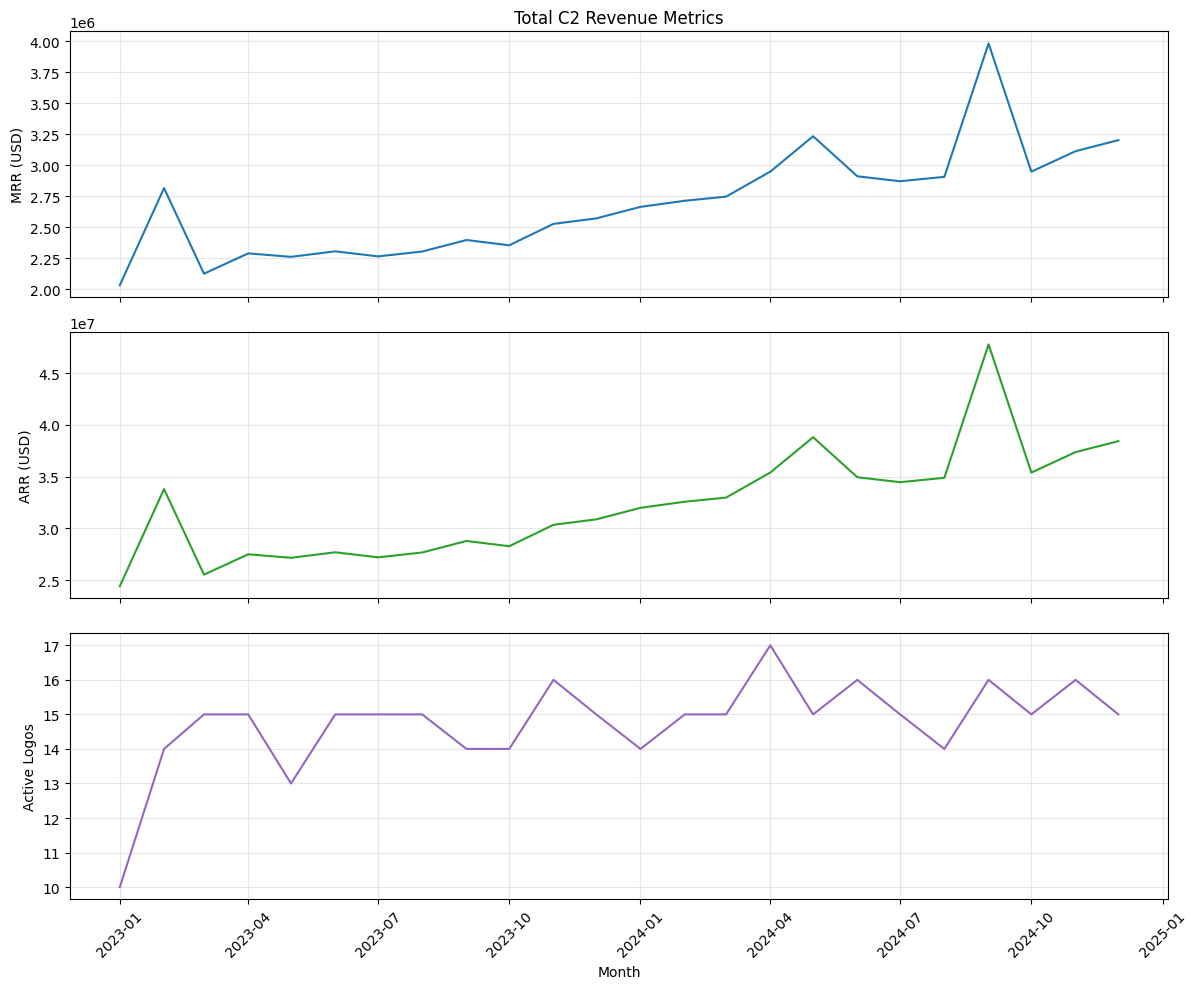

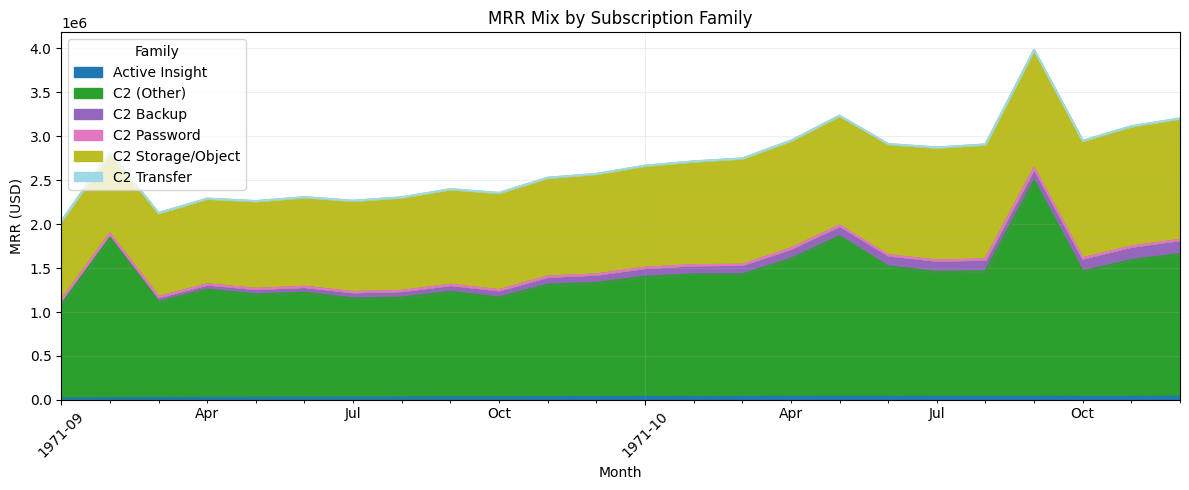

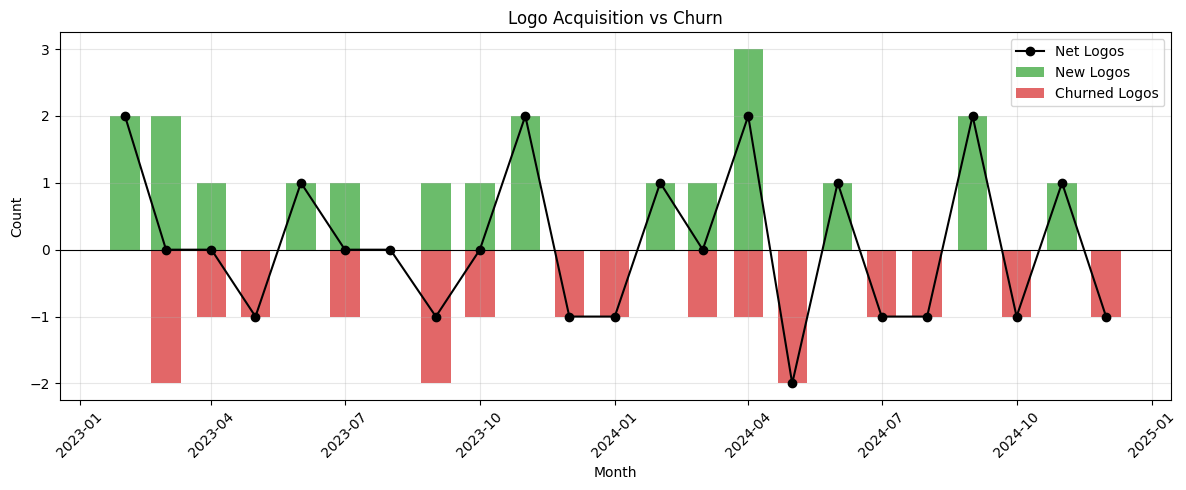

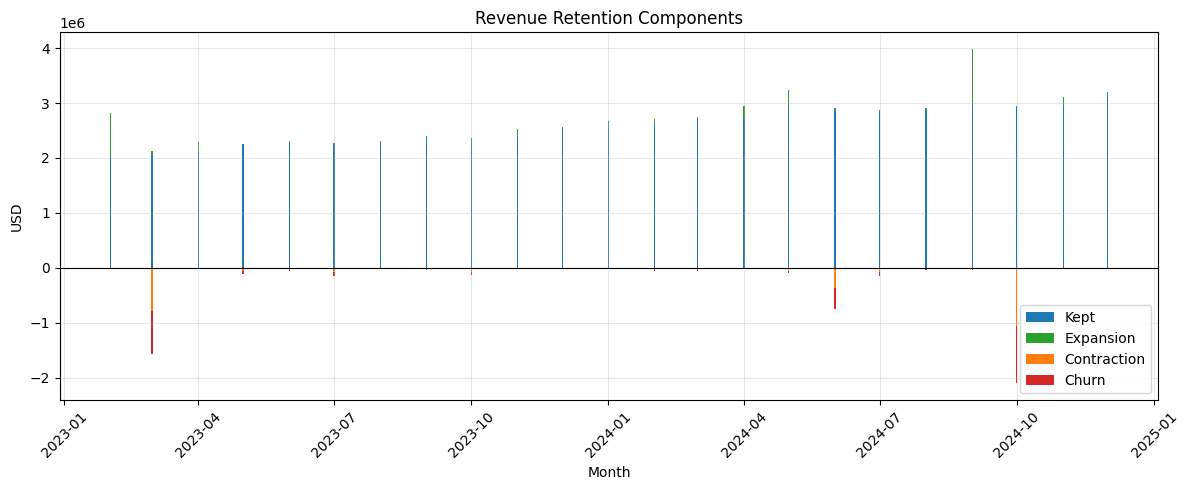

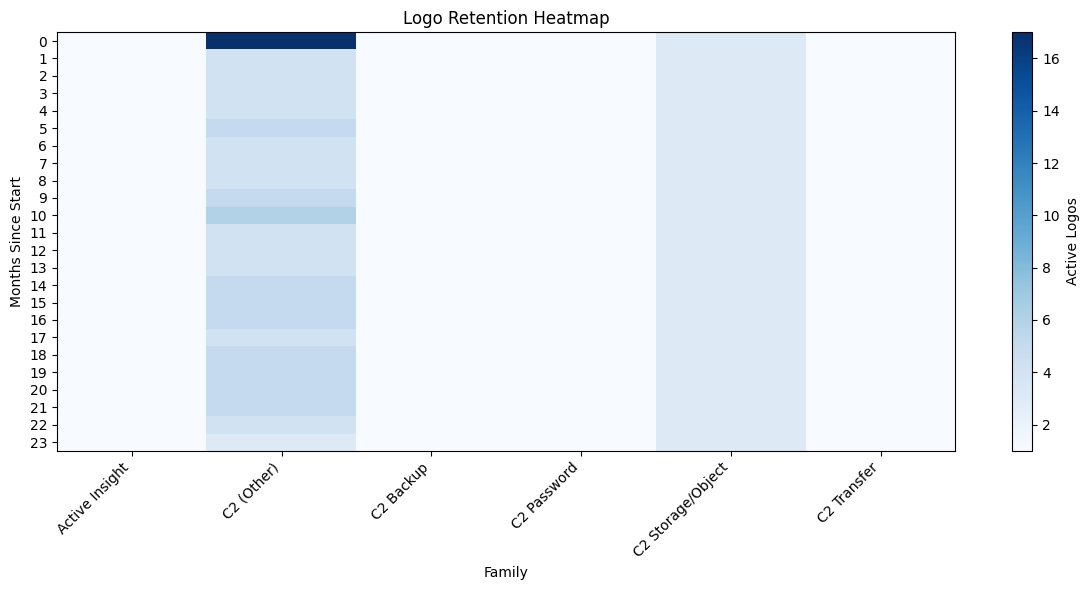

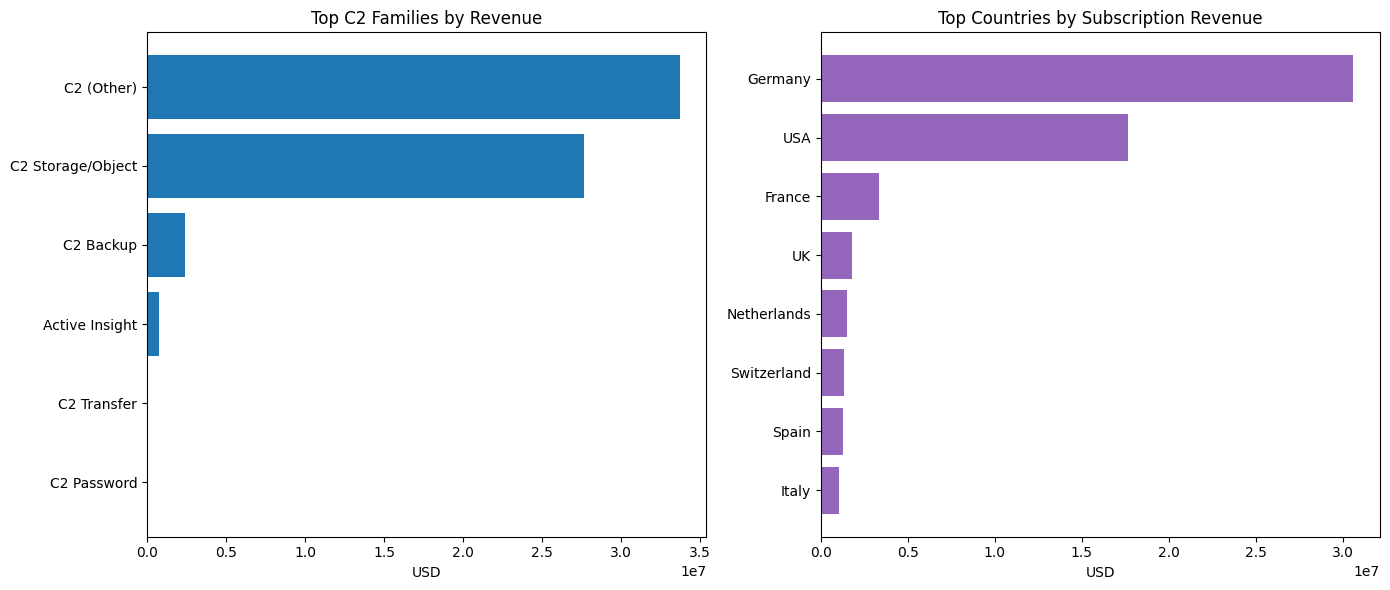

In [22]:

from IPython.display import display
import matplotlib.dates as mdates

print("=== Tabular Rollups ===")
if not monthly.empty:
    display(monthly.sort_values(['YearMonth', 'Family']).head(15))
else:
    print("No monthly family records available.")

if not total_monthly.empty:
    display(total_monthly.sort_values('YearMonth').tail(12))
else:
    print("No total monthly metrics available.")

if not logo_stats.empty:
    display(logo_stats.tail(12))
else:
    print("Logo transition table is empty.")

if not revenue_churn.empty:
    display(revenue_churn.tail(12))
else:
    print("Revenue churn components are empty.")

if not retention.empty:
    retention_preview = retention.pivot_table(
        index='MonthsSinceStart', columns='Family', values='active_logos', aggfunc='sum'
    ).fillna(0)
    display(retention_preview.head(12))
else:
    print("Retention table is empty.")

if not family_summary.empty:
    display(family_summary.head(10))
if not country_subs.empty:
    display(country_subs.head(10))

print("=== Visual Summaries ===")
if not total_monthly.empty:
    ordered_total = total_monthly.sort_values('YearMonth')
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    axes[0].plot(ordered_total['YearMonth'], ordered_total['MRR_Total'], color='tab:blue', label='MRR')
    axes[0].set_ylabel('MRR (USD)')
    axes[0].set_title('Total C2 Revenue Metrics')
    axes[0].grid(True, alpha=0.3)
    axes[1].plot(ordered_total['YearMonth'], ordered_total['ARR_Total'], color='tab:green', label='ARR')
    axes[1].set_ylabel('ARR (USD)')
    axes[1].grid(True, alpha=0.3)
    axes[2].plot(ordered_total['YearMonth'], ordered_total['ActiveSubs_Total'], color='tab:purple', label='Active Subs')
    axes[2].set_ylabel('Active Logos')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlabel('Month')
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

family_pivot = (
    monthly.pivot_table(index='YearMonth', columns='Family', values='MRR', aggfunc='sum').fillna(0)
    if not monthly.empty else None
)
if family_pivot is not None and not family_pivot.empty:
    family_pivot = family_pivot.sort_index()
    ax = family_pivot.plot.area(figsize=(12, 5), colormap='tab20')
    ax.set_title('MRR Mix by Subscription Family')
    ax.set_xlabel('Month')
    ax.set_ylabel('MRR (USD)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

if not logo_stats.empty:
    logo_plot = logo_stats.sort_values('Month').copy()
    logo_plot['Month'] = pd.to_datetime(logo_plot['Month'])
    fig, ax = plt.subplots(figsize=(12, 5))
    width = 20  # days
    ax.bar(logo_plot['Month'], logo_plot['NewLogos'], width=width, label='New Logos', color='tab:green', alpha=0.7)
    ax.bar(logo_plot['Month'], -logo_plot['ChurnedLogos'], width=width, label='Churned Logos', color='tab:red', alpha=0.7)
    ax.plot(logo_plot['Month'], logo_plot['NetLogos'], color='black', marker='o', label='Net Logos')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title('Logo Acquisition vs Churn')
    ax.set_ylabel('Count')
    ax.set_xlabel('Month')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if not revenue_churn.empty:
    rev_plot = revenue_churn.sort_values('Month').copy()
    rev_plot['Month'] = pd.to_datetime(rev_plot['Month'])
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(rev_plot['Month'], rev_plot['KeptRevenue'], label='Kept', color='tab:blue')
    ax.bar(rev_plot['Month'], rev_plot['ExpansionRevenue'], bottom=rev_plot['KeptRevenue'], label='Expansion', color='tab:green')
    contraction = -rev_plot['ContractionRevenue']
    ax.bar(rev_plot['Month'], contraction, label='Contraction', color='tab:orange')
    ax.bar(rev_plot['Month'], -rev_plot['ChurnedRevenue'], bottom=contraction, label='Churn', color='tab:red')
    ax.set_title('Revenue Retention Components')
    ax.set_ylabel('USD')
    ax.set_xlabel('Month')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if not retention.empty:
    retention_matrix = (
        retention.pivot_table(index='MonthsSinceStart', columns='Family', values='active_logos', aggfunc='sum')
        .fillna(0)
        .sort_index()
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(retention_matrix.values, aspect='auto', cmap='Blues')
    ax.set_xticks(range(len(retention_matrix.columns)))
    ax.set_xticklabels(retention_matrix.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(retention_matrix.index)))
    ax.set_yticklabels(retention_matrix.index)
    ax.set_xlabel('Family')
    ax.set_ylabel('Months Since Start')
    ax.set_title('Logo Retention Heatmap')
    fig.colorbar(im, ax=ax, label='Active Logos')
    plt.tight_layout()
    plt.show()

if not family_summary.empty or not country_subs.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    if not family_summary.empty:
        top_families = family_summary.head(8).iloc[::-1]
        axes[0].barh(top_families['Family'], top_families['RevenueUSD'], color='tab:blue')
        axes[0].set_title('Top C2 Families by Revenue')
        axes[0].set_xlabel('USD')
    else:
        axes[0].text(0.5, 0.5, 'No family data', ha='center')
        axes[0].axis('off')
    if not country_subs.empty:
        top_countries = country_subs.head(8).iloc[::-1]
        axes[1].barh(top_countries['Country'], top_countries['RevenueUSD'], color='tab:purple')
        axes[1].set_title('Top Countries by Subscription Revenue')
        axes[1].set_xlabel('USD')
    else:
        axes[1].text(0.5, 0.5, 'No country data', ha='center')
        axes[1].axis('off')
    plt.tight_layout()
    plt.show()
